In [2]:

import importlib
import proshestic_processor.prosthetic_hand_data_processor as prosthetic_hand_data_processor
importlib.reload(prosthetic_hand_data_processor)

from proshestic_processor.prosthetic_hand_data_processor import ProstheticHandDataProcessor

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import lightgbm as lgb

import optuna



In [3]:
# Создаем df на базе считанных данных о файлах данных пилотов
pilot_files = pd.read_csv('./data/meta_information.csv')
# выбираем файлы для указанного пилота
pilote_id = 4
# создаем список файлов, котносящихся к указанному пилоту
palm_file = pilot_files[pilot_files.pilote_id == pilote_id].montage.apply(lambda x: './data/'+x).tolist()
# palm_file = './data/2023-06-05_16-12-38.palm'

In [4]:
# Создаем обьект на основе класса ProstheticHandDataProcessor
processor = ProstheticHandDataProcessor(
                              palm_file, # Список файлов с данными
                              pilote_id = pilote_id,# id пилота 
                              n_omg_channels=50, # количество каналов данных в файле
                              n_acc_channels=3, # количество каналов акселометра
                              n_gyr_channels=3, # количество каналов гироскопа
                              n_enc_channels=6, # количество кодированных каналов
                              n_mag_channels=0)

Всего файлов:                            1
Чтение файла значений:                   ./data/2023-05-05_17-57-30.palm
Чтение файла протокола жестов:           ./data/2023-05-05_17-57-30.palm
Количество записей:                      26648
Срезаем с и до:                          425 <> 26622
----------------------------------------------------------------------------------------------------
Итоговый размер датасета:                (26197, 66)


## Рабочий процесс создания данных для модели. Вариант 2

Автоматизируем процесс обработки данных пилота и выбора сильных признаков.
* На основе данных о косинусном сходстве, выбираем сильные признаки.
* На каждом шаге убираем самый слабый признак
В итоге получаем и записываем статистику каждой из построенной модели

В итоге смотрим, при каком кол-ве признаков и каких признаках, модель была наилучшей для указанного пилота

In [6]:
processor.vectors_cousine()
steps = processor.get_cosine_steps(15)[:-3]
steps

Создание словаря с векторами в формате [сенсор][жест][шаг][значения], доступен через <object>.vectors 
Расчет косинусного сходства между векторами, сгруппированными по сенсорам, доступны через <object>.vectors_sum 
Создадим дополнительные признаки, путем ссумирования подряд по 5 сенсоров
Доступны через <object>.additional_features_1
 
Создадим векторы на базе additional_features_1 и интерполируем их
Доступны через <object>.additional_features_1_vector
 
Рассчитаем косинусную схожесть на векторе additional_features_1_vector
Доступны через <object>.additional_features_1_cosine_mean
 


[0.9905319180489384,
 0.9925627066156896,
 0.9951980959448136,
 0.9955254149945446,
 0.9963504471641859,
 0.9969451175154417,
 0.9970201301831263,
 0.9970666606587495,
 0.9982768790213704,
 0.9983578304922849,
 0.9991275901734709]

In [6]:
selection_params = {
    'cosine' : 0,
    'sensor_power' : 25,
    'cosine_add_feature_1' : .9962329743225542,
    'shift' : (0,0)
}

lgb_params = {
    'n_estimators' : 1000,         # Количество деревьев
    'learning_rate' : 0.02,         # Скорость обучения
    'max_depth' : -1,              # Максимальная глубина деревьев (по умолчанию нет ограничений)
    'min_child_samples' : 20,      # Минимальное число образцов в листьях
    'subsample' : 0.8,             # Доля выборки для обучения каждого дерева
    'random_state' : 42            # Для воспроизводимости
}

rf_params = {
    'n_estimators': 50,          # Количество деревьев
    'max_depth': 40,             # Ограничение глубины деревьев
    'min_samples_split': 5,      # Минимум 5 выборок для разделения
    'min_samples_leaf': 3,       # Минимум 3 выборки в листе
    'max_features': 'log2',      # Количество признаков для каждого разделения
    'random_state': 42
}


### Процесс моделирования с разным набором признаков

In [5]:
steps_additional_1 = processor.additional_features_1_cosine_mean

In [7]:
steps_add = sorted(steps_additional_1.values())[-4:]

In [21]:
for steps_a in steps_add:
    for step in steps:
        selection_params['cosine'] = step
        selection_params['cosine_add_feature_1'] = steps_a
        processor.fit_and_predict(pilote_id, 'rf', rf_params, selection_params, use_add=False, stat_file = 'st.json' )

    for step in steps:
        selection_params['cosine'] = step
        selection_params['cosine_add_feature_1'] = steps_a
        processor.fit_and_predict(pilote_id, 'rf', rf_params, selection_params, use_add=True, stat_file = 'st.json' )    


Максимальная сила сигнала: 3643.0
['3', '4', '5', '6', '12', '13', '16', '21', '22', '27', '28', '30', '38', '39']
['new_feature_1', 'new_feature_3', 'new_feature_7']
Новый объект добавлен успешно.
Максимальная сила сигнала: 3643.0
['3', '4', '5', '6', '12', '13', '16', '21', '22', '27', '30', '38', '39']
['new_feature_1', 'new_feature_3', 'new_feature_7']
Новый объект добавлен успешно.
Максимальная сила сигнала: 3643.0
['3', '4', '5', '6', '12', '13', '16', '21', '22', '30', '38', '39']
['new_feature_1', 'new_feature_3', 'new_feature_7']
Новый объект добавлен успешно.
Максимальная сила сигнала: 3643.0
['3', '4', '5', '6', '12', '13', '16', '21', '22', '30', '39']
['new_feature_1', 'new_feature_3', 'new_feature_7']
Новый объект добавлен успешно.
Максимальная сила сигнала: 3643.0
['3', '4', '5', '6', '12', '13', '21', '22', '30', '39']
['new_feature_1', 'new_feature_3', 'new_feature_7']
Новый объект добавлен успешно.
Максимальная сила сигнала: 3643.0
['3', '4', '5', '6', '12', '13', '22

### Получение статистики

Получение данных их файла статистики, о лучшей и худшей моделях для Random Forest алгоритма и LGB

In [5]:
print(f'''ID пилота: {pilote_id}''')
model_stat = processor.get_min_max_stat_for_pilote(pd.read_json('st.json'),pilote_id)
model_stat


ID пилота: 4


{'lgb': {'min': 0.9834158850537036,
  'min_id': 217,
  'max': 0.9935855615740742,
  'max_id': 73},
 'rf': {'min': 0.9688166372907409,
  'min_id': 66,
  'max': 0.9834577211611112,
  'max_id': 56}}

Просмотр деталей статитсики для лучшей модели для random Forest алгоритма

In [6]:
max_rf = model_stat['rf']['max_id']
max_rf_value = model_stat['rf']['max']
processor.get_statistic_by_id(pd.read_json('st.json'),max_rf)

precision                         recall                      \
        stat_train stat_test stat_init stat_train stat_test stat_init   
Neutral      0.992     0.976     0.989      0.998     0.989     0.997   
Open         0.999     1.000     1.000      0.990     0.958     0.984   
Pistol       0.999     0.981     0.996      0.987     0.968     0.983   
Thumb        0.994     0.980     0.991      0.982     0.952     0.975   
OK           0.998     0.970     0.993      0.988     0.944     0.979   
Grab         0.996     0.959     0.988      0.989     0.959     0.983   

          f1-score                      
        stat_train stat_test stat_init  
Neutral      0.995     0.982     0.993  
Open         0.995     0.979     0.992  
Pistol       0.993     0.974     0.989  
Thumb        0.988     0.966     0.983  
OK           0.993     0.956     0.986  
Grab         0.993     0.959     0.986

Теперь, подобрав лучший набор признаков для модели, можем получить из файла статистики, при аких параметрах, данная модель была создана и далее попытаться настроить гиперпараметры для получения лучшего результата.

In [7]:
# прочтем файл статистики
stat = processor.get_stat('st.json')
best_model_params = processor.get_model_params_by_id(stat, max_rf)
best_params = processor.get_params_by_id(stat, max_rf)

In [8]:
# параметры модели, можем отталкиваться от них при настройке гиперпараметров
best_model_params

{'rf': {'n_estimators': 100,
  'max_depth': 40,
  'min_samples_split': 5,
  'min_samples_leaf': 3,
  'max_features': 'log2',
  'random_state': 42}}

In [9]:
# данные отбора признаков
best_params

{'cosine': 0.990531918048938,
 'sensor_power': 25,
 'cosine_add_feature_1': 0.999,
 'use_add': False,
 'shift': <bound method NDFrame.shift of cosine                   0.991
 sensor_power                25
 cosine_add_feature_1     0.999
 use_add                  False
 shift                   [0, 0]
 features_num                14
 features_add_1_num           0
 Name: 56, dtype: object>,
 'features_num': 14,
 'features_add_1_num': 0}

## Рабочий процесс создания данных для модели. Вариант 1

Строим модель на основе данных статистики и будем пытаться получить лучшие параметры для модели

In [10]:
# Инициализируем основные данные для текущей модели
processor.vectors_cousine()

# Применяем паарметры отбора для данных
processor.change_params_and_apply(best_params['cosine'],best_params['sensor_power'],best_params['cosine_add_feature_1'],(0,0))

# Получаем данные для обучения модели
X,X_init,y = processor.model_data_prepare(best_params['use_add'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Создание словаря с векторами в формате [сенсор][жест][шаг][значения], доступен через <object>.vectors 
Расчет косинусного сходства между векторами, сгруппированными по сенсорам, доступны через <object>.vectors_sum 
Создадим дополнительные признаки, путем ссумирования подряд по 5 сенсоров
Доступны через <object>.additional_features_1
 
Создадим векторы на базе additional_features_1 и интерполируем их
Доступны через <object>.additional_features_1_vector
 
Рассчитаем косинусную схожесть на векторе additional_features_1_vector
Доступны через <object>.additional_features_1_cosine_mean
 
Максимальная сила сигнала: 3643.0
['3', '4', '5', '6', '12', '13', '16', '17', '21', '22', '27', '28', '30', '38', '39']
[]


### Давайте посмотрим на графике, какие входные данные мы имеем по каждому из каналов

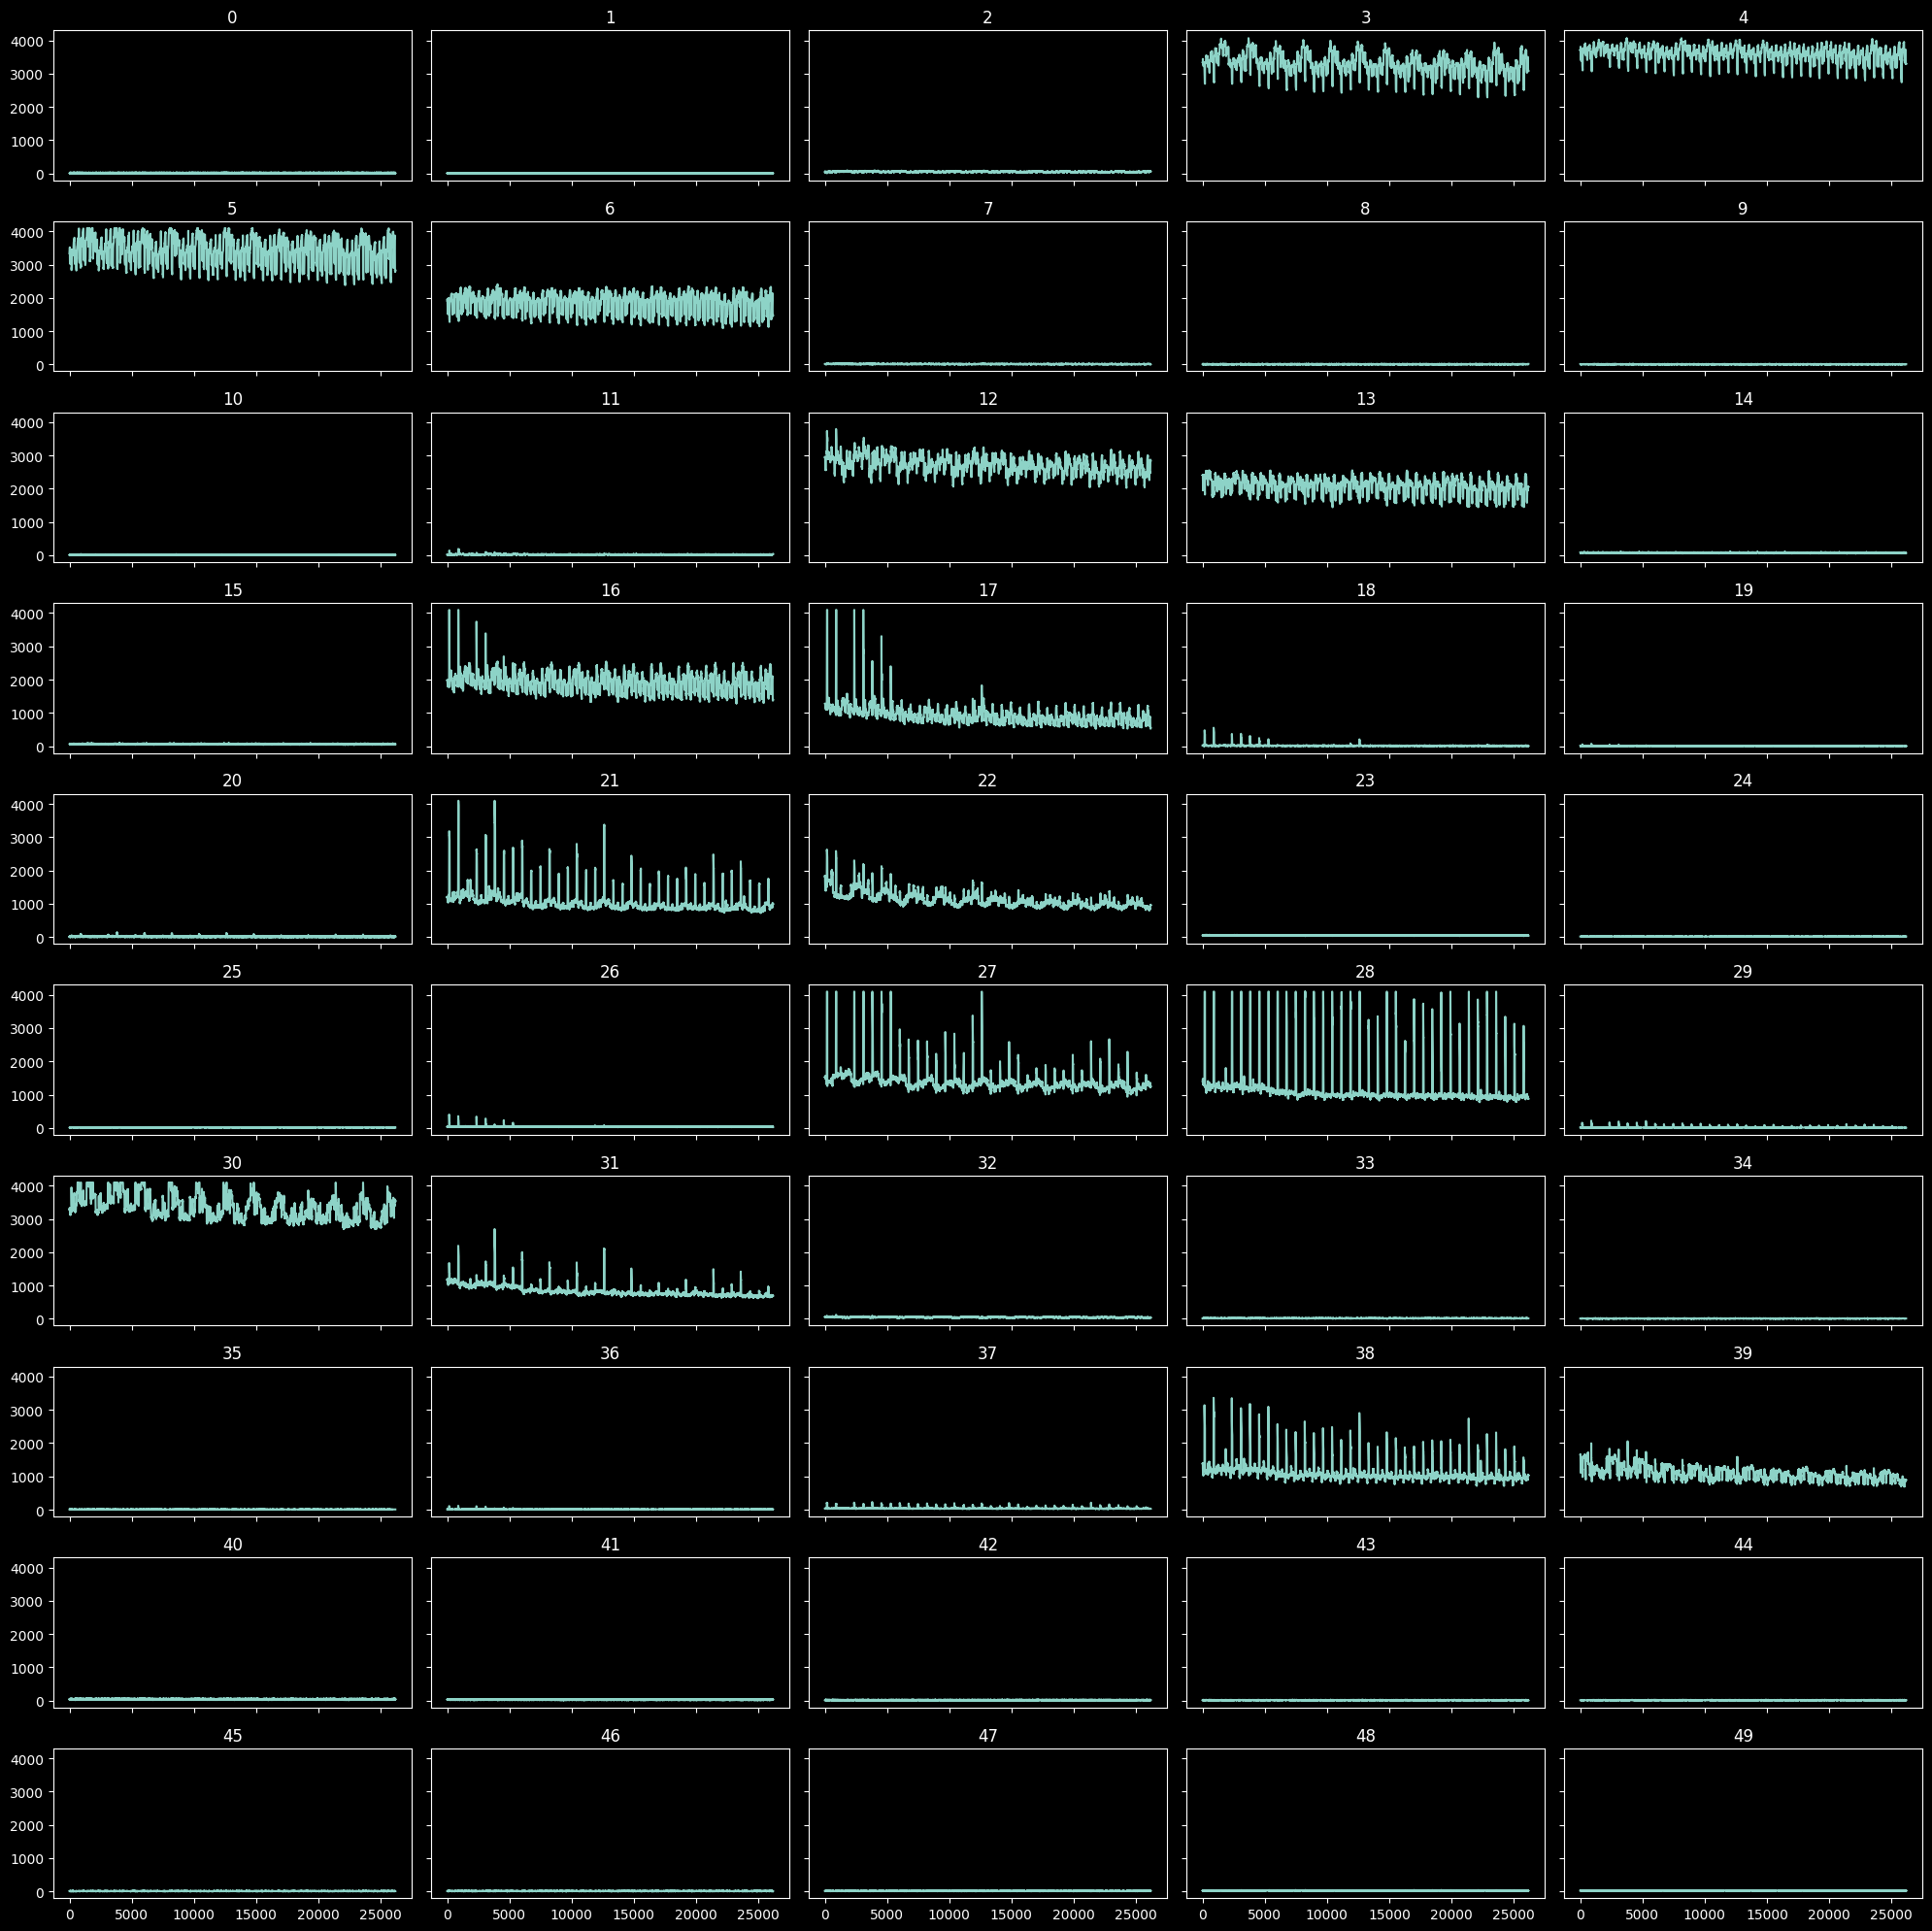

In [15]:
processor.plot_sensors(processor.OMG_CH, range(processor.gestures.shape[0]))

### Какие сенсоры алгортим отобрал для последующего обучения модели

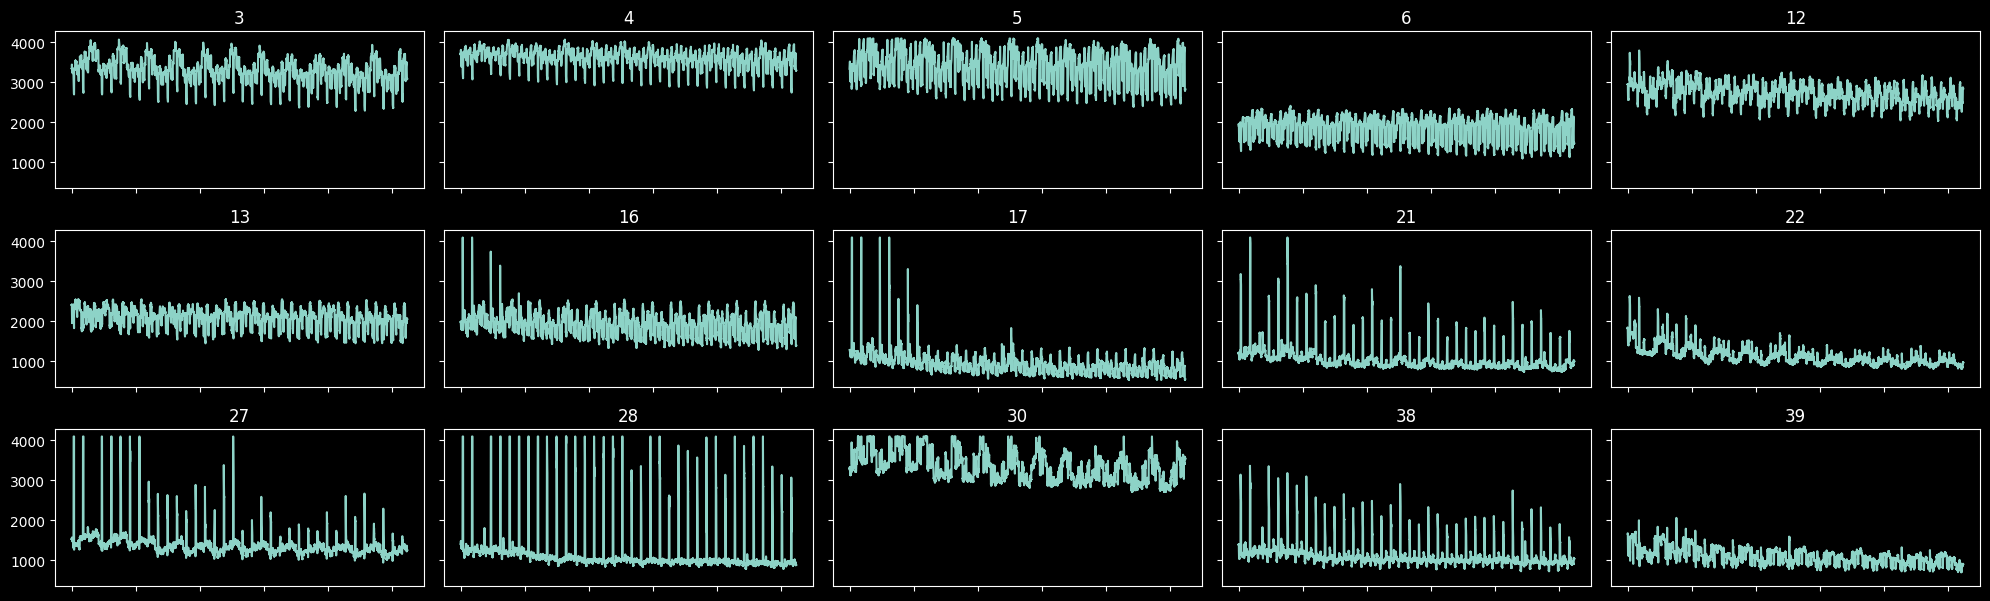

In [16]:
processor.plot_sensors(processor.CLEAN_SENSORS_FINAL+processor.CLEAN_SENSORS_ADD_FEATURE_1, range(processor.gestures.shape[0]))

### Также посмотрим результат работы смещения для начала и окончания жеста

* На графике присутствуют сигналы тех сенсоров, что были отобраны для данной модели
* На втором графике мы видим дисперсию по отобранным сигналам
* Третий график, это информация о изначальном начале и конце жеста
* Четвертый график, результат работы алгоритма смещения, скорректировавший реальное начало и окончание жеста



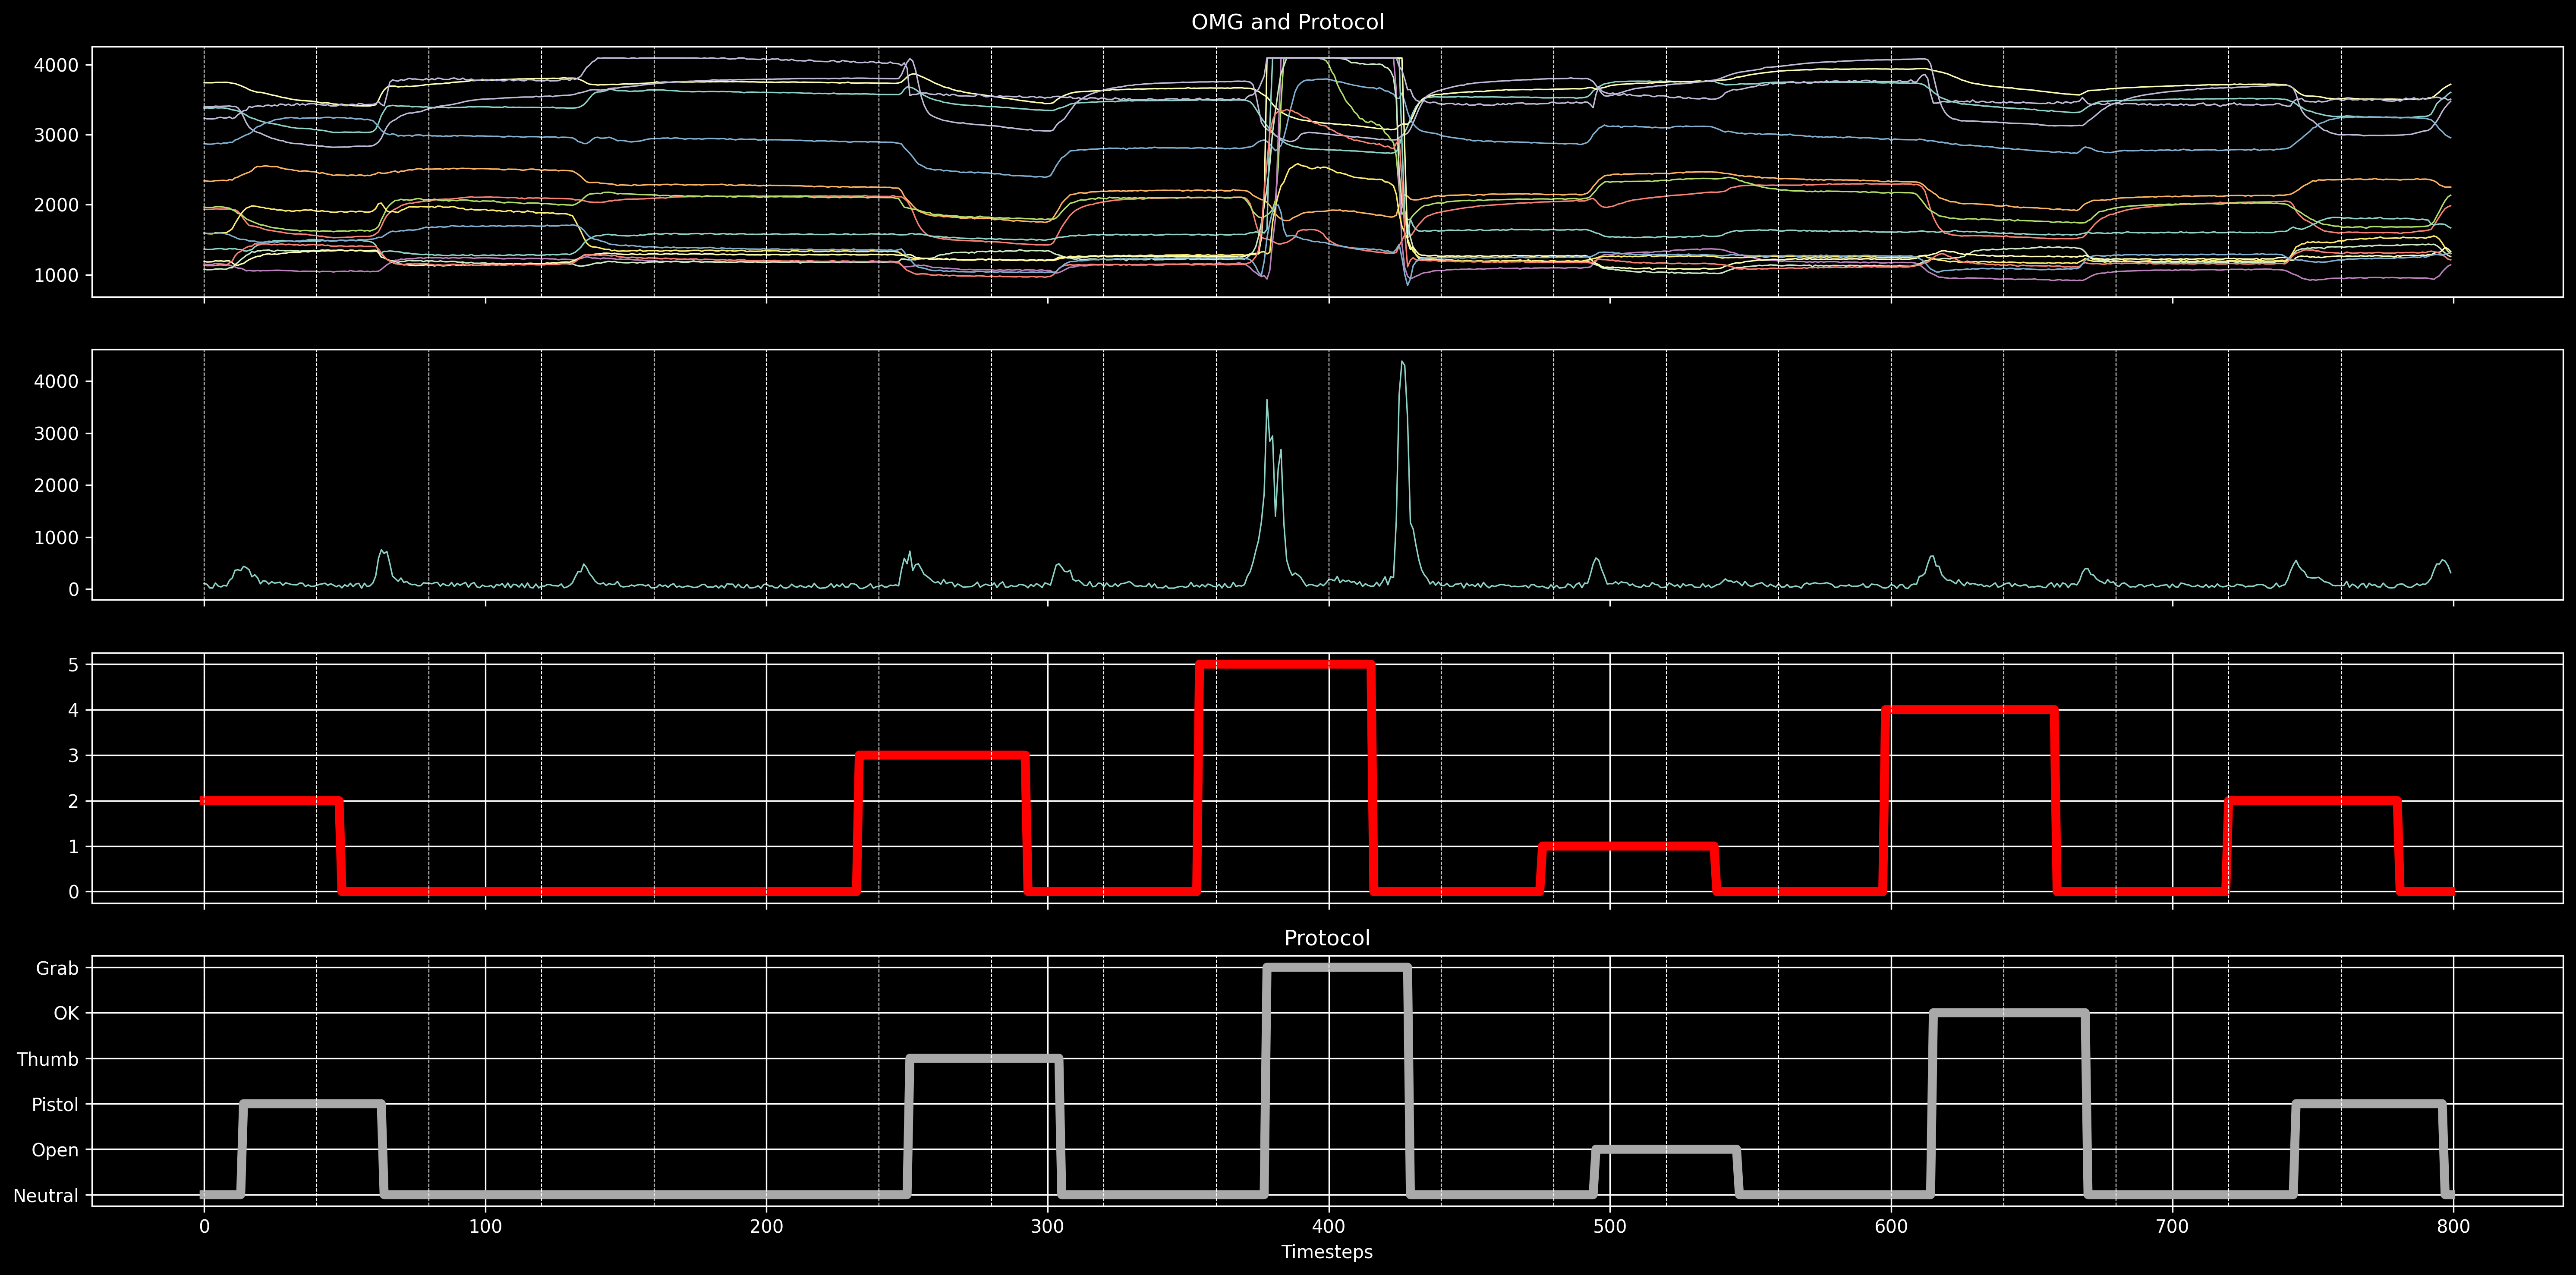

In [17]:
processor.graph_sensor_gestures(range(500, 1300),2)

### Подбор гипперпараметров

Теперь попытаемся подобрать лучший набор параметров для модели Random Forest

In [11]:

def objective(trial):
    # Предлагаем значения гиперпараметров
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42
    }
    
    # Инициализируем модель с текущими гиперпараметрами
    model = RandomForestClassifier(**rf_params)
    
    # Оцениваем модель с помощью кросс-валидации
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='f1_weighted').mean()
    
    return score

# Настраиваем исследование с Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Выводим результаты
print("Лучшие гиперпараметры: ", study.best_params)
print("Лучший результат: ", study.best_value)



[I 2024-10-09 19:09:36,097] A new study created in memory with name: no-name-cf2b00a0-e29d-4b46-8c43-361136c63da1
[I 2024-10-09 19:09:44,569] Trial 0 finished with value: 0.9737135732875416 and parameters: {'n_estimators': 76, 'max_depth': 84, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9737135732875416.
[I 2024-10-09 19:09:52,632] Trial 1 finished with value: 0.9726065255267252 and parameters: {'n_estimators': 74, 'max_depth': 45, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.9737135732875416.
[I 2024-10-09 19:09:54,809] Trial 2 finished with value: 0.9705969448911014 and parameters: {'n_estimators': 20, 'max_depth': 75, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.9737135732875416.
[I 2024-10-09 19:10:12,532] Trial 3 finished with value: 0.9717486561836073 and parameters: {'n_estimators': 167, 'max_depth': 78, 'min

Лучшие гиперпараметры:  {'n_estimators': 140, 'max_depth': 97, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Лучший результат:  0.9789905801426252


### Построим модель Random Forest на найденных лучших параметрах 

In [12]:
model = RandomForestClassifier(**study.best_params)
model.fit(X = X_train, y=y_train)

RandomForestClassifier(max_depth=97, n_estimators=140)

### Сделаем предсказание

In [13]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_train_init = model.predict(X_init)

### Построим график реальной и предсказанной целевой величины на всем датасете

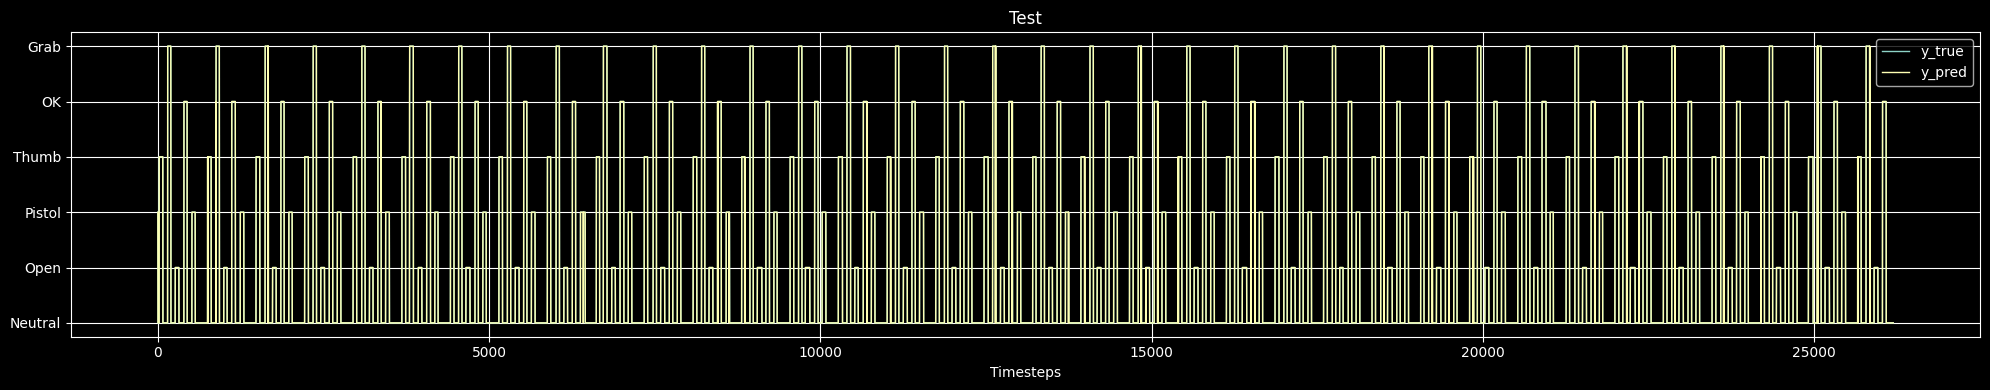

In [14]:
processor.plot_results(y, y_pred_train_init, (20,4), 1)

### Запишем полученные данные статистики в файл статистики

In [15]:

processor.get_statistic(y_train, y_pred_train,1, False)
processor.get_statistic(y_test, y_pred_test,2, False)
processor.get_statistic(y, y_pred_train_init,3, False)

model_parameters = processor.get_params()
model_parameters['model_params'] = study.best_params
model_parameters['model'] = 'rf'
processor.save_stat('st.json', model_parameters)


Новый объект добавлен успешно.


### Перечитаем файл статистики, чтобы узнать id последней записи

In [16]:
stat = processor.get_stat('st.json')
last_rf_idx = stat.iloc[-1].name
last_rf_idx

253

In [17]:
processor.get_statistic_by_id(pd.read_json('st.json'),max_rf)

precision                         recall                      \
        stat_train stat_test stat_init stat_train stat_test stat_init   
Neutral      0.992     0.976     0.989      0.998     0.989     0.997   
Open         0.999     1.000     1.000      0.990     0.958     0.984   
Pistol       0.999     0.981     0.996      0.987     0.968     0.983   
Thumb        0.994     0.980     0.991      0.982     0.952     0.975   
OK           0.998     0.970     0.993      0.988     0.944     0.979   
Grab         0.996     0.959     0.988      0.989     0.959     0.983   

          f1-score                      
        stat_train stat_test stat_init  
Neutral      0.995     0.982     0.993  
Open         0.995     0.979     0.992  
Pistol       0.993     0.974     0.989  
Thumb        0.988     0.966     0.983  
OK           0.993     0.956     0.986  
Grab         0.993     0.959     0.986

In [18]:
processor.get_statistic_by_id(pd.read_json('st.json'),last_rf_idx)

precision                         recall                      \
        stat_train stat_test stat_init stat_train stat_test stat_init   
Neutral      1.000     0.979     0.996      1.000     0.990     0.998   
Open         1.000     0.992     0.999      1.000     0.965     0.993   
Pistol       1.000     0.986     0.997      1.000     0.973     0.995   
Thumb        1.000     0.978     0.995      1.000     0.960     0.991   
OK           1.000     0.978     0.996      1.000     0.951     0.991   
Grab         1.000     0.969     0.994      1.000     0.959     0.992   

          f1-score                      
        stat_train stat_test stat_init  
Neutral      1.000     0.984     0.997  
Open         1.000     0.979     0.996  
Pistol       1.000     0.980     0.996  
Thumb        1.000     0.969     0.993  
OK           1.000     0.964     0.993  
Grab         1.000     0.964     0.993

In [19]:
last_rf_value = processor.get_min_max_stat_for_pilote(pd.read_json('st.json'),pilote_id)['rf']['max']
print(f'Сравним. Максимально полученное значение для пилота: {pilote_id} \nс подбором признаков -              {max_rf_value} \nс подбором гиперпараметров модели : {last_rf_value}')

Сравним. Максимально полученное значение для пилота: 4 
с подбором признаков -              0.9834577211611112 
с подбором гиперпараметров модели : 0.9893477194314815


### Замерим inference

In [21]:
df_sim = processor.gestures.iloc[-100:,:-1]
df_sim
processor.inference(model,df_sim)

Среднее время предсказания: 0.007429, что составляет 22.51% от требуемого лимита


In [22]:

processor.clean_sensor_getter_by_cosine(.99)
processor.median_sensor_power_getter()
processor.clean_sensor_getter_by_power(25)


Максимальная сила сигнала: nan
Выбор сенсоров с сильным сигналом, доступны через <object>.CLEAN_SENSORS_FINAL 


[]

In [7]:
processor.get_vectors_final()
processor.get_df_final()

Создание словаря с векторами только для выбранных сенсоров в формате [сенсор][жест][шаг][значения],
 доступны через <object>.vectors_final 
Создание pd.DataFrame для выбранных сенсоров,
 доступны через <object>.gestures_clean
 


In [ ]:
processor.get_neutral_vectors()
processor.get_vector_median_length()
processor.get_median_vectors()

In [10]:
# processor.get_min_max_for_senser()
# processor.vector_correction_all()

In [35]:
processor.create_additional_features_1()
processor.create_additional_features_1_vector()
processor.calculate_additional_features_1_cosine()


In [ ]:
processor.additional_features_1_vector

In [32]:
# processor.plot_sensors(processor.additional_features_1.columns, range(processor.additional_features_1.shape[0]),'af1')

<Figure size 2000x2000 with 0 Axes>

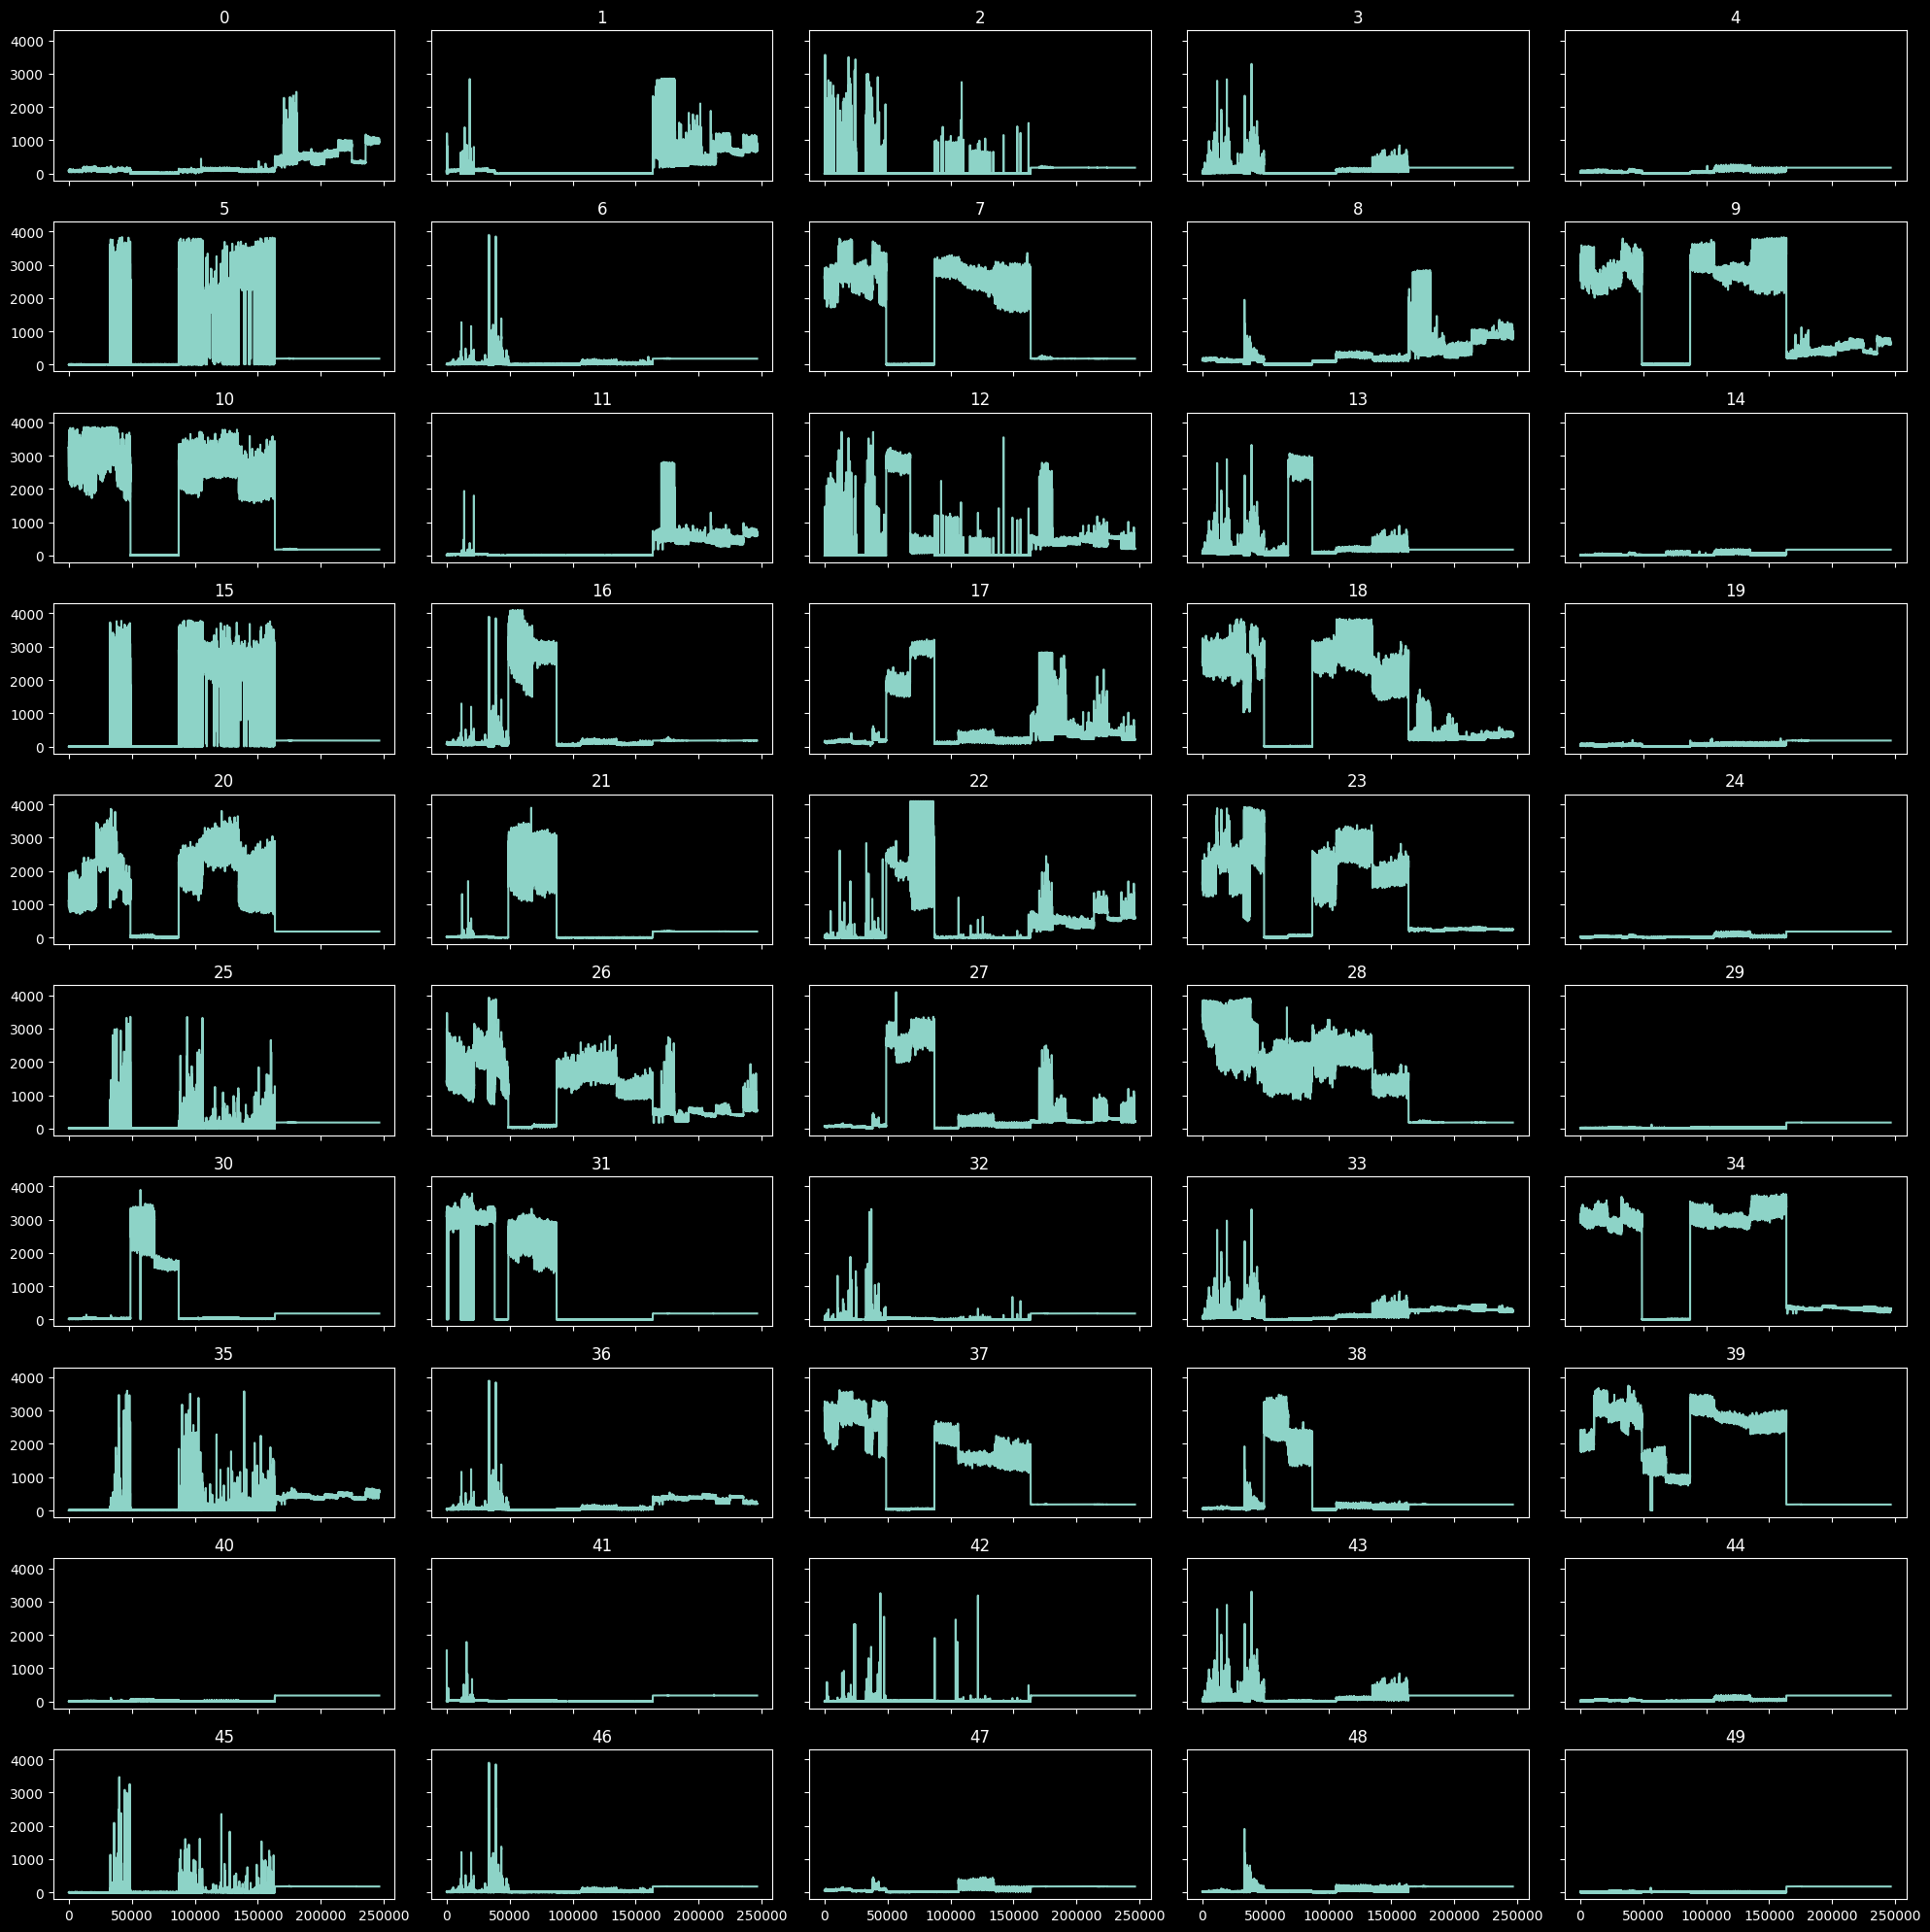

In [31]:
processor.plot_sensors(processor.OMG_CH, range(processor.gestures.shape[0]))
# processor.plot_sensors(processor.CLEAN_SENSORS_FINAL, range(processor.gestures.shape[0]),'hh')

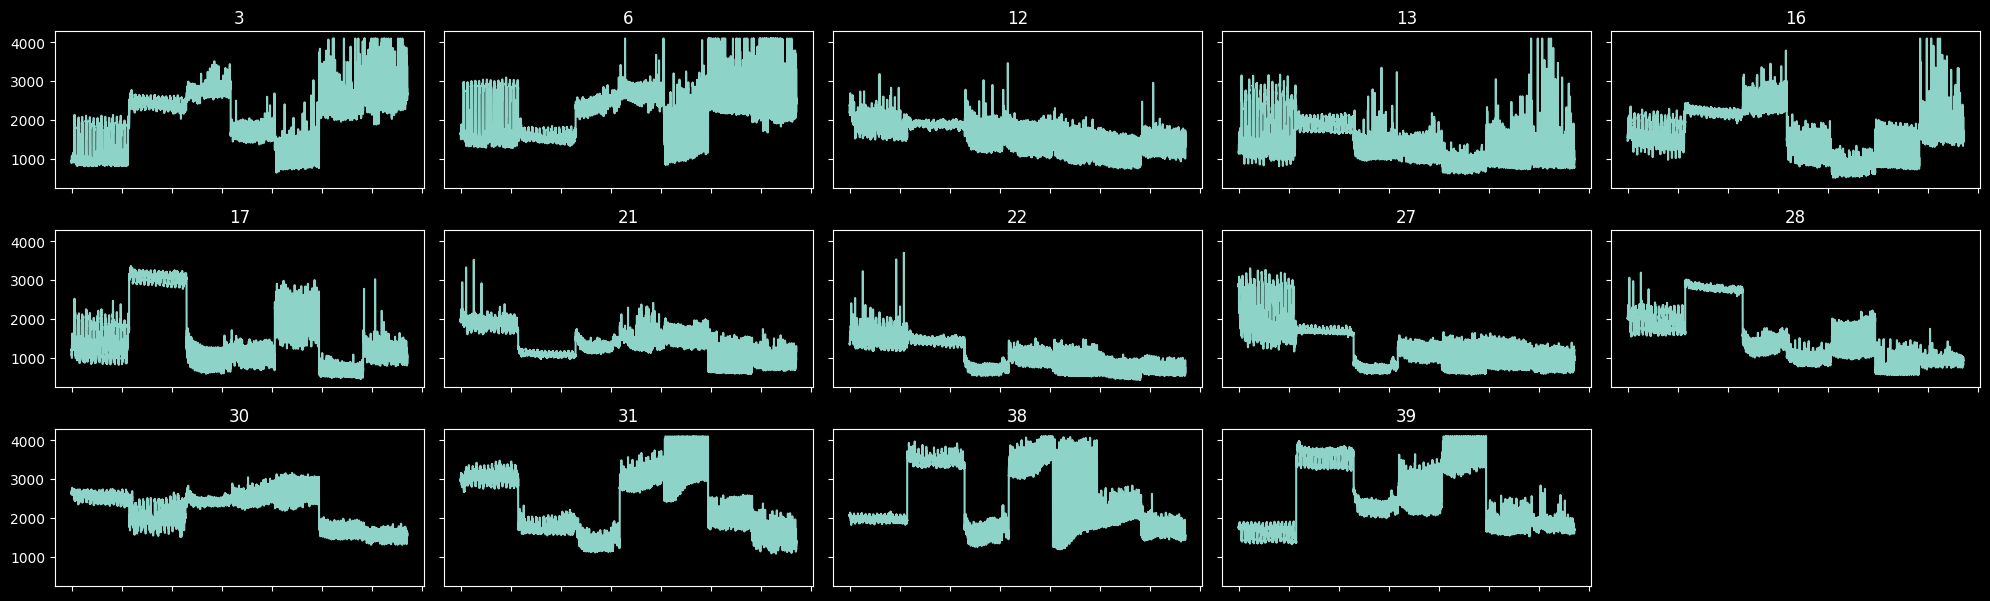

In [14]:

processor.plot_sensors(processor.CLEAN_SENSORS_FINAL, range(processor.gestures.shape[0]),'init')

In [15]:
# processor.plotly_sensor(0,'38','f')

In [17]:

processor.cleaned_df_diff_adding()

In [18]:
processor.create_fix_gestures_df(shift = (-1,0))

Создаем таблицу смещения
Доступны через <object>.changes_df_info
 
Делаем смещение начало и конца жеста, согласно changes_df_info 


In [ ]:
processor.graph_sensor_gestures(range(500, 1300),2)
# range_ = range(500, 1300)
# range_ = range(7400,8200)
# range_ = range(0,500)

In [37]:
processor.vectors_cousine()
steps = processor.get_cosine_steps(15)[:-3]
steps

[0.948338576319666,
 0.9743323544736795,
 0.9800759681224147,
 0.9868991646184442,
 0.9894925636942193,
 0.989698846508104,
 0.9935822256469482]

In [ ]:
processor.vectors_cousine()

In [30]:


processor.change_params_and_apply(0.90,25,.80,(0,0))
X,X_init,y = processor.model_data_prepare(True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Максимальная сила сигнала: 2726.0
['7', '9', '10', '18', '20', '23', '26', '28', '34', '37', '39']
[]
Датасет с дополнительными признаками нулевой!!!


## Modeling

In [25]:
selection_params = {
    'cosine' : .98,
    'sensor_power' : 25,
    'cosine_add_feature_1' : .999,
    'shift' : (0,0)
}

lgb_params = {
    'n_estimators' : 1000,         # Количество деревьев
    'learning_rate' : 0.02,         # Скорость обучения
    'max_depth' : -1,              # Максимальная глубина деревьев (по умолчанию нет ограничений)
    'min_child_samples' : 20,      # Минимальное число образцов в листьях
    'subsample' : 0.8,             # Доля выборки для обучения каждого дерева
    'random_state' : 42            # Для воспроизводимости
}

rf_params = {
    'n_estimators': 50,          # Количество деревьев
    'max_depth': 40,             # Ограничение глубины деревьев
    'min_samples_split': 5,      # Минимум 5 выборок для разделения
    'min_samples_leaf': 3,       # Минимум 3 выборки в листе
    'max_features': 'log2',      # Количество признаков для каждого разделения
    'random_state': 42
}

# lgb_params = {
#     'n_estimators' : 2000,         # Количество деревьев
#     'learning_rate' : 0.1,         # Скорость обучения
#     'max_depth' : -1,              # Максимальная глубина деревьев (по умолчанию нет ограничений)
#     'min_child_samples' : 20,      # Минимальное число образцов в листьях
#     'subsample' : 0.8,             # Доля выборки для обучения каждого дерева
#     'random_state' : 42            # Для воспроизводимости
# }

# rf_params = {
#     'n_estimators': 100,          # Количество деревьев
#     'max_depth': 40,             # Ограничение глубины деревьев
#     'min_samples_split': 5,      # Минимум 5 выборок для разделения
#     'min_samples_leaf': 3,       # Минимум 3 выборки в листе
#     'max_features': 'log2',      # Количество признаков для каждого разделения
#     'random_state': 42
# }

In [ ]:
for step in steps:
    selection_params['cosine'] = step
    processor.fit_and_predict(pilote_id, 'rf', rf_params, selection_params, use_add=False, stat_file = 'st.json' )

# for step in steps:
#     selection_params['cosine'] = step
#     processor.fit_and_predict(pilote_id, 'rf', rf_params, selection_params, use_add=True, stat_file = 'st.json' )    

# for step in steps:
#     selection_params['cosine'] = step
#     processor.fit_and_predict(pilote_id, 'lgb', lgb_params, selection_params, use_add=False, stat_file = 'st.json' )

# for step in steps:
#     selection_params['cosine'] = step
#     processor.fit_and_predict(pilote_id, 'lgb', lgb_params, selection_params, use_add=True, stat_file = 'st.json' )    

In [24]:
# processor.fit_and_predict(pilote_id, 'rf', rf_params, selection_params, use_add=False, stat_file = 'st.json' )

In [98]:
print(f'''ID пилота: {pilote_id}''')
processor.get_min_max_stat_for_pilote(pd.read_json('st.json'),pilote_id)
processor.get_min_max_stat_for_pilote(pd.read_json('st.json'),4)

ID пилота: 4


{'lgb': {'min': 0.9834158850537036,
  'min_id': 217,
  'max': 0.9935855615740742,
  'max_id': 73},
 'rf': {'min': 0.9688166372907409,
  'min_id': 66,
  'max': 0.9834577211611112,
  'max_id': 56}}

In [65]:
processor.get_statistic_by_id(pd.read_json('st.json'),102)


precision                         recall                      \
        stat_train stat_test stat_init stat_train stat_test stat_init   
Neutral      1.000     0.945     0.989      1.000     0.973     0.995   
Open         1.000     0.968     0.994      1.000     0.937     0.987   
Pistol       1.000     0.942     0.989      1.000     0.884     0.977   
Thumb        1.000     0.934     0.987      1.000     0.881     0.976   
OK           1.000     0.950     0.990      1.000     0.903     0.980   
Grab         1.000     0.958     0.992      1.000     0.921     0.985   

          f1-score                      
        stat_train stat_test stat_init  
Neutral      1.000     0.959     0.992  
Open         1.000     0.952     0.991  
Pistol       1.000     0.912     0.983  
Thumb        1.000     0.907     0.982  
OK           1.000     0.926     0.985  
Grab         1.000     0.939     0.989

In [29]:
processor.get_statistic_by_id(pd.read_json('st.json'),230)

precision                         recall                      \
        stat_train stat_test stat_init stat_train stat_test stat_init   
Neutral      0.987     0.961     0.982      0.998     0.989     0.996   
Open         0.993     0.975     0.990      0.974     0.909     0.961   
Pistol       0.995     0.963     0.989      0.982     0.950     0.975   
Thumb        0.997     0.968     0.991      0.974     0.889     0.957   
OK           0.992     0.955     0.985      0.977     0.932     0.968   
Grab         0.998     0.989     0.996      0.985     0.946     0.977   

          f1-score                      
        stat_train stat_test stat_init  
Neutral      0.992     0.975     0.989  
Open         0.983     0.941     0.975  
Pistol       0.988     0.956     0.982  
Thumb        0.985     0.927     0.974  
OK           0.985     0.943     0.976  
Grab         0.991     0.967     0.987

In [7]:
stat = processor.get_stat('st.json')
print(processor.get_model_params_by_id(stat, 73))
print(processor.get_params_by_id(stat, 73))

{'lgb': {'n_estimators': 2000, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.8, 'random_state': 42}}
{'cosine': 0.9970201301831261, 'sensor_power': 25, 'cosine_add_feature_1': 0.999, 'use_add': False, 'shift': <bound method NDFrame.shift of cosine                  0.99702
sensor_power                 25
cosine_add_feature_1      0.999
use_add                   False
shift                    [0, 0]
features_num                  8
features_add_1_num            0
Name: 73, dtype: object>, 'features_num': 8, 'features_add_1_num': 0}


In [8]:
processor.vectors_cousine()
processor.change_params_and_apply(processor.get_params_by_id(stat, 73)['cosine'],25,.999,(0,0))

X,X_init,y = processor.model_data_prepare(False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Создание словаря с векторами в формате [сенсор][жест][шаг][значения], доступен через <object>.vectors 
Расчет косинусного сходства между векторами, сгруппированными по сенсорам, доступны через <object>.vectors_sum 
Максимальная сила сигнала: 3643.0
['3', '4', '5', '6', '12', '13', '22', '30', '39']
[]


In [6]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(20957, 9) (20957,)
(5240, 9) (5240,)


In [ ]:
model = RandomForestClassifier(**rf_params)
model.fit(X = X_train, y=y_train)

model_lgb = lgb.LGBMClassifier(**processor.get_model_params_by_id(stat, 241)['lgb'])
model_lgb.fit(X_train, y_train)

In [7]:
y_pred_train = model_lgb.predict(X_train)
y_pred_test = model_lgb.predict(X_test)
y_pred_train_init = model_lgb.predict(X_init)

In [8]:
y_train.shape

(20957,)

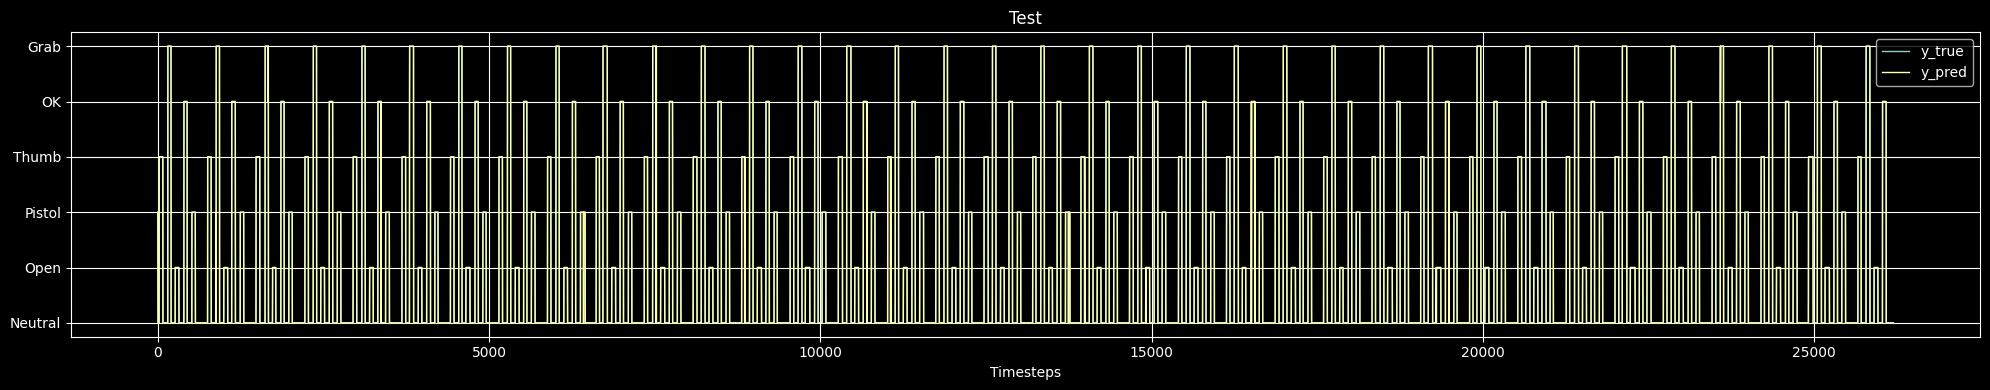

In [12]:
y_pred_train = model_lgb.predict(X_train)
y_pred_test = model_lgb.predict(X_test)
y_pred_train_init = model_lgb.predict(X_init)
processor.plot_results(y, y_pred_train_init, (20,4), 1)

### Перечитаем файл статистики, чтобы узнать id последней записи

pilote_id                                                                      3
cosine                                                                     0.990
sensor_power                                                                  25
cosine_add_feature_1                                                       0.999
clean_sensor_final                                                [3, 4, 16, 39]
clean_sensors_add_feature_1                                                   []
use_add                                                                    False
shift                                                                     [0, 0]
random_state                                                                  42
test_size                                                                  0.200
model                                                                        lgb
model_params                   {'n_estimators': 1000, 'learning_rate': 0.02, ...
precision.Neutral           

In [14]:
df_sim = processor.gestures.iloc[-100:,:-1]
df_sim
processor.inference(model_lgb,df_sim)

Среднее время предсказания: 0.003915, что составляет 11.86% от требуемого лимита


In [33]:
# processor.plot_results(y_test, y_pred_test, (20,4), .2)

In [34]:
# processor.get_statistic(y_train, y_pred_train,1)


In [35]:
# processor.get_statistic(y_test, y_pred_test,2)

In [36]:
# y_pred_train_init = model.predict(X_init)


In [37]:
# processor.plot_results(y, y_pred_train_init, (20,4), 1)


In [38]:
# processor.get_statistic(y, y_pred_train_init,3)

In [39]:
# results = pd.DataFrame([y,y_pred_train_init]).transpose().rename(columns={0: 'train',1:'pred'})

In [40]:
# model_parameters = processor.get_params()
# model_parameters['rf_params'] = rf_params
# model_parameters['model'] = 'rf'
# processor.save_stat('stats.json', model_parameters)

In [86]:
stat = processor.get_stat('st.json')

In [88]:
stat.filter(regex='^(recall|f1|shift)').tail(7)


,shift,recall.Neutral,recall.Open,recall.Pistol,recall.Thumb,recall.OK,recall.Grab,f1-score.Neutral,f1-score.Open,f1-score.Pistol,f1-score.Thumb,f1-score.OK,f1-score.Grab
249,"[0, 0]",0.994,0.957,0.970,0.922,0.957,0.986,0.985,0.973,0.979,0.950,0.970,0.990
250,"[0, 0]",0.992,0.950,0.953,0.888,0.938,0.976,0.981,0.966,0.966,0.928,0.952,0.984
251,"[0, 0]",0.989,0.893,0.933,0.867,0.923,0.966,0.973,0.934,0.947,0.908,0.940,0.978
252,"[0, 0]",0.982,0.803,0.887,0.788,0.872,0.926,0.955,0.872,0.911,0.839,0.899,0.951
253,"[0, 0]",0.993,0.900,0.905,0.899,0.884,0.954,0.973,0.941,0.941,0.940,0.926,0.967
254,"[0, 0]",0.993,0.905,0.912,0.901,0.889,0.954,0.974,0.943,0.944,0.940,0.929,0.968
255,"[0, 0]",0.991,0.888,0.901,0.886,0.869,0.947,0.970,0.932,0.934,0.928,0.915,0.963


In [43]:
# processor.get_min_max_stat_for_pilote(pd.read_json('stats.json'),pilote_id)

In [44]:
processor.get_model_params_by_id(stat, 50)
processor.get_params_by_id(stat, 50)

{'cosine': 0.974332354473679,
 'sensor_power': 25,
 'cosine_add_feature_1': 0.999,
 'use_add': True,
 'shift': <bound method NDFrame.shift of cosine                   0.974
 sensor_power                25
 cosine_add_feature_1     0.999
 use_add                   True
 shift                   [0, 0]
 features_num                 9
 features_add_1_num           1
 Name: 50, dtype: object>,
 'features_num': 9,
 'features_add_1_num': 1}

In [45]:
# processor.get_params_by_id(stat, 16)

In [46]:
# processor.get_statistic_by_id(pd.read_json('st.json'),10)

In [47]:

# processor.get_statistic_by_id(pd.read_json('st.json'),16)

In [48]:
# model_params = {
#     'n_estimators' : 2000,         # Количество деревьев
#     'learning_rate' : 0.02,         # Скорость обучения
#     'max_depth' : -1,              # Максимальная глубина деревьев (по умолчанию нет ограничений)
#     'min_child_samples' : 20,      # Минимальное число образцов в листьях
#     'subsample' : 0.8,             # Доля выборки для обучения каждого дерева
#     'random_state' : 42            # Для воспроизводимости
# }

# model_lgb = lgb.LGBMClassifier(**model_params)

# # Кросс-валидация
# cv_scores = cross_val_score(model_lgb, X_train, y_train, cv=5, scoring='accuracy')
# print(f'Средняя точность кросс-валидации: {np.mean(cv_scores):.4f}')

# # Обучение модели
# model_lgb.fit(X_train, y_train)

In [49]:
# model_parameters = processor.get_params()
# model_parameters['model_params'] = model_params
# model_parameters['model'] = 'lgb'
# processor.save_stat('stats.json', model_parameters)

In [50]:
# y_pred_train = model_lgb.predict(X_train)
# y_pred_test = model_lgb.predict(X_test)
# y_pred_train_init = model.predict(X_init)

In [51]:
# processor.get_statistic(y_train, y_pred_train,1)

In [52]:
# processor.get_statistic(y_train, y_pred_train,1)
# processor.get_statistic(y_test, y_pred_test,2)
# processor.get_statistic(y, y_pred_train_init,3)

In [53]:
# processor.get_statistic(y, y_pred_train_init,3)

0.0036300325393676756